#### 1.Install necessary libraries

In [134]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Model
from catboost import CatBoostRegressor, Pool

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

#### 2. Load and Explore Data

In [135]:
# Load the dataset
df = pd.read_csv('../data/car_price.csv')

# Remove the first column (ID column - unnamed index)
df = df.drop(df.columns[0], axis=1)

#### 3. Data Preprocessing

In [136]:
# Create a copy for preprocessing
df_processed = df.copy()

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Price')  # Remove target variable


In [137]:
# Handle missing values
print("=" * 60)
print("HANDLING MISSING VALUES")
print("=" * 60)

# Check for missing values
missing_before = df_processed.isnull().sum().sum()
print(f"\nTotal missing values before: {missing_before}")

# Fill numerical missing values with median
for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"   • {col}: Filled with median = {median_val:.2f}")

# Fill categorical missing values with mode
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        mode_val = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_val, inplace=True)
        print(f"   • {col}: Filled with mode = {mode_val}")

missing_after = df_processed.isnull().sum().sum()
print(f"\nTotal missing values after: {missing_after}")

HANDLING MISSING VALUES

Total missing values before: 0

Total missing values after: 0


In [138]:
# Feature Engineering
print("=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Drop Date column
df_processed['Date'] = pd.to_datetime(df_processed['Date'])
df_processed = df_processed.drop('Date', axis=1)

# Convert YOM to Car_Age (current year - YOM)
current_year = 2026
df_processed['Car_Age'] = current_year - df_processed['YOM']
df_processed = df_processed.drop('YOM', axis=1)
print(f"✅ Converted YOM to Car_Age (2026 - YOM)")
print(f"   Car_Age range: {df_processed['Car_Age'].min()} - {df_processed['Car_Age'].max()} years")

# Scale down Millage(KM) by dividing by 100 and rounding up
df_processed['Millage'] = np.ceil(df_processed['Millage(KM)'] / 100)
df_processed = df_processed.drop('Millage(KM)', axis=1)
print(f"✅ Scaled Millage(KM) → Millage (divided by 100, rounded up)")
print(f"   Millage range: {df_processed['Millage'].min()} - {df_processed['Millage'].max()}")

# Keep only the selected features + target
feature_cols = ['Brand', 'Model', 'Engine (cc)', 'Gear', 'Fuel Type', 'Car_Age', 'Millage']
df_processed = df_processed[feature_cols + ['Price']]

print(f"\n✅ Final features: {feature_cols}")
print(f"   Categorical: Brand, Model, Gear, Fuel Type")
print(f"   Numerical: Car_Age, Engine (cc), Millage")

# Create price bins for stratified splitting
df_processed['Price_Bin'] = pd.qcut(df_processed['Price'], q=5, labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'])

print(f"\nDataset shape: {df_processed.shape}")
df_processed.head()

FEATURE ENGINEERING
✅ Converted YOM to Car_Age (2026 - YOM)
   Car_Age range: 2 - 70 years
✅ Scaled Millage(KM) → Millage (divided by 100, rounded up)
   Millage range: 110.0 - 7590.0

✅ Final features: ['Brand', 'Model', 'Engine (cc)', 'Gear', 'Fuel Type', 'Car_Age', 'Millage']
   Categorical: Brand, Model, Gear, Fuel Type
   Numerical: Car_Age, Engine (cc), Millage

Dataset shape: (9788, 9)


,Brand,Model,Engine (cc),Gear,Fuel Type,Car_Age,Millage,Price,Price_Bin
0,AUDI,A1,990.0,Automatic,Petrol,10,990.0,100.0,Very_High
1,AUDI,A1,1000.0,Automatic,Petrol,9,880.0,97.0,Very_High
2,AUDI,A1,1000.0,Automatic,Petrol,8,770.0,98.5,Very_High
3,AUDI,A1,1000.0,Automatic,Petrol,9,880.0,107.0,Very_High
4,AUDI,A1,1000.0,Automatic,Petrol,9,880.0,99.5,Very_High


#### 4. Data Splitting (Train-Validation-Test)

In [139]:
# Prepare features and target
print("=" * 60)
print("STRATIFIED DATA SPLITTING")
print("=" * 60)

# Create stratification key combining Brand and Price_Bin
df_processed['Stratify_Key'] = df_processed['Brand'].astype(str) + '_' + df_processed['Price_Bin'].astype(str)

# Handle rare combinations by grouping them
stratify_counts = df_processed['Stratify_Key'].value_counts()
rare_combinations = stratify_counts[stratify_counts < 2].index
df_processed.loc[df_processed['Stratify_Key'].isin(rare_combinations), 'Stratify_Key'] = 'Other'

# Separate features and target
X = df_processed.drop(['Price', 'Price_Bin', 'Stratify_Key'], axis=1)
y = df_processed['Price']
stratify_key = df_processed['Stratify_Key']

# Define categorical features explicitly
cat_features = ['Brand', 'Model', 'Gear', 'Fuel Type']

# Numerical features: Car_Age, Engine (cc), Millage
numerical_features = ['Car_Age', 'Engine (cc)', 'Millage']

print(f"\nFeatures Shape: {X.shape}")
print(f"Target Shape: {y.shape}")
print(f"\nCategorical Features: {cat_features}")
print(f"Numerical Features: {numerical_features}")
print(f"\nFeature columns: {X.columns.tolist()}")

STRATIFIED DATA SPLITTING

Features Shape: (9788, 7)
Target Shape: (9788,)

Categorical Features: ['Brand', 'Model', 'Gear', 'Fuel Type']
Numerical Features: ['Car_Age', 'Engine (cc)', 'Millage']

Feature columns: ['Brand', 'Model', 'Engine (cc)', 'Gear', 'Fuel Type', 'Car_Age', 'Millage']


In [140]:
# Perform stratified train-validation-test split
# Using 70-15-15 split to maximize training data while maintaining validation/test sets
# Step 1: Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp, stratify_train, stratify_temp = train_test_split(
    X, y, stratify_key,
    test_size=0.3, 
    random_state=42, 
    stratify=stratify_key
)

# Step 2: Rebuild stratify key for temp set (handle rare combinations again)
stratify_temp_counts = stratify_temp.value_counts()
rare_temp = stratify_temp_counts[stratify_temp_counts < 2].index
stratify_temp_adjusted = stratify_temp.copy()
stratify_temp_adjusted[stratify_temp_adjusted.isin(rare_temp)] = 'Other'

# Step 3: Split temp into validation (15%) and test (15%) — 50/50 of the 30%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, 
    random_state=42, 
    stratify=stratify_temp_adjusted
)

print("\nStratified Train-Validation-Test Split Completed!")
print(f"\nTraining Set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation Set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test Set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify stratification - compare brand distributions
print("\nBrand Distribution Comparison:")
train_brand_dist = X_train['Brand'].value_counts(normalize=True).head(5)
val_brand_dist = X_val['Brand'].value_counts(normalize=True).head(5)
test_brand_dist = X_test['Brand'].value_counts(normalize=True).head(5)

comparison_df = pd.DataFrame({
    'Train %': train_brand_dist * 100,
    'Validation %': val_brand_dist * 100,
    'Test %': test_brand_dist * 100
}).round(2)
print(comparison_df)

# Verify price distribution similarity
print("\n Price Distribution Comparison:")
print(f"   Train      - Mean: {y_train.mean():.2f}, Median: {y_train.median():.2f}, Std: {y_train.std():.2f}")
print(f"   Validation - Mean: {y_val.mean():.2f}, Median: {y_val.median():.2f}, Std: {y_val.std():.2f}")
print(f"   Test       - Mean: {y_test.mean():.2f}, Median: {y_test.median():.2f}, Std: {y_test.std():.2f}")


Stratified Train-Validation-Test Split Completed!

Training Set:   6851 samples (70.0%)
Validation Set: 1468 samples (15.0%)
Test Set:       1469 samples (15.0%)

Brand Distribution Comparison:
            Train %  Validation %  Test %
Brand                                    
TOYOTA        31.57         31.40   31.65
SUZUKI        25.27         25.20   25.32
NISSAN        12.74         12.74   12.80
HONDA          6.96          6.95    6.94
MITSUBISHI     2.92          2.86    2.86

 Price Distribution Comparison:
   Train      - Mean: 53.30, Median: 43.00, Std: 43.27
   Validation - Mean: 53.61, Median: 43.75, Std: 43.80
   Test       - Mean: 54.08, Median: 42.50, Std: 45.11


#### 5. Model Training


In [141]:
# Get categorical feature indices from training data
cat_features = ['Brand', 'Model', 'Gear', 'Fuel Type']
cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_features]

print(f"✅ Categorical Features ({len(cat_features)}): {cat_features}")
print(f"✅ Categorical Feature Indices: {cat_feature_indices}")

# Create CatBoost Pools
train_pool = Pool(
    data=X_train, 
    label=y_train, 
    cat_features=cat_feature_indices
)

val_pool = Pool(
    data=X_val, 
    label=y_val, 
    cat_features=cat_feature_indices
)

test_pool = Pool(
    data=X_test, 
    label=y_test, 
    cat_features=cat_feature_indices
)

print(f"\n✅ CatBoost Pools created successfully!")
print(f"   Training Pool:   {train_pool.num_row()} samples, {train_pool.num_col()} features")
print(f"   Validation Pool: {val_pool.num_row()} samples, {val_pool.num_col()} features")
print(f"   Test Pool:       {test_pool.num_row()} samples, {test_pool.num_col()} features")

✅ Categorical Features (4): ['Brand', 'Model', 'Gear', 'Fuel Type']
✅ Categorical Feature Indices: [0, 1, 3, 4]

✅ CatBoost Pools created successfully!
   Training Pool:   6851 samples, 7 features
   Validation Pool: 1468 samples, 7 features
   Test Pool:       1469 samples, 7 features


In [142]:
# Initialize and train CatBoost model with optimized hyperparameters
print("=" * 60)
print("TRAINING CATBOOST MODEL (OPTIMIZED)")
print("=" * 60)

model = CatBoostRegressor(
    iterations=3000,           # More iterations for better convergence
    learning_rate=0.02,        # Smaller learning rate for finer gradient steps
    depth=10,                  # Deep trees for complex patterns
    l2_leaf_reg=1,             # Low regularization for flexibility
    min_data_in_leaf=3,        # Small leaf size to capture more patterns
    random_strength=0.3,       # Reduced randomness for stability
    bagging_temperature=0.2,   # Lower for less randomness in bagging
    border_count=254,          # Fine splits on numerical features
    grow_policy='Lossguide',   # Better for complex patterns
    max_leaves=64,             # Control tree complexity
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=200,
    early_stopping_rounds=200, # More patience for convergence
    use_best_model=True
)

print("\n🚀 Starting model training...\n")
print("   Using VALIDATION set for early stopping (test set remains unseen)\n")
model.fit(
    train_pool,
    eval_set=val_pool,
    plot=False
)

print(f"\n✅ Model training completed!")
print(f"   Best iteration: {model.get_best_iteration()}")

TRAINING CATBOOST MODEL (OPTIMIZED)

🚀 Starting model training...

   Using VALIDATION set for early stopping (test set remains unseen)

0:	learn: 42.5809430	test: 43.1181616	best: 43.1181616 (0)	total: 207ms	remaining: 10m 21s
0:	learn: 42.5809430	test: 43.1181616	best: 43.1181616 (0)	total: 207ms	remaining: 10m 21s
200:	learn: 10.2375376	test: 15.2458246	best: 15.2458246 (200)	total: 35.7s	remaining: 8m 17s
200:	learn: 10.2375376	test: 15.2458246	best: 15.2458246 (200)	total: 35.7s	remaining: 8m 17s
400:	learn: 8.6106884	test: 14.7415744	best: 14.7415744 (400)	total: 1m 10s	remaining: 7m 34s
400:	learn: 8.6106884	test: 14.7415744	best: 14.7415744 (400)	total: 1m 10s	remaining: 7m 34s
600:	learn: 7.9005896	test: 14.5544168	best: 14.5542484 (599)	total: 1m 44s	remaining: 6m 57s
600:	learn: 7.9005896	test: 14.5544168	best: 14.5542484 (599)	total: 1m 44s	remaining: 6m 57s
800:	learn: 7.4383940	test: 14.4336377	best: 14.4336377 (800)	total: 2m 18s	remaining: 6m 20s
800:	learn: 7.4383940	t

#### 6. Model Evaluation

In [143]:
# Make predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, set_name):
    """Calculate and return regression metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'Set': set_name,
        'RMSE': rmse,
        'MAE': mae,
        'R² Score': r2,
        'MAPE (%)': mape
    }

# Calculate metrics for all three sets
train_metrics = calculate_metrics(y_train, y_train_pred, 'Training')
val_metrics = calculate_metrics(y_val, y_val_pred, 'Validation')
test_metrics = calculate_metrics(y_test, y_test_pred, 'Test')

# Display results
print("=" * 60)
print("MODEL EVALUATION RESULTS")
print("=" * 60)
print("\n Performance Metrics (Price in 100,000s LKR):\n")

metrics_df = pd.DataFrame([train_metrics, val_metrics, test_metrics])
metrics_df = metrics_df.set_index('Set')
print(metrics_df.round(4).to_string())

# Interpretation
print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print(f"""
 Validation Set Performance (used for early stopping):
   R² Score: {val_metrics['R² Score']:.4f} → Explains {val_metrics['R² Score']*100:.2f}% of variance
   RMSE: {val_metrics['RMSE']:.4f} → Avg error: ~{val_metrics['RMSE']*100000:.0f} LKR

 Test Set Performance (completely unseen during training):
   R² Score: {test_metrics['R² Score']:.4f} → Explains {test_metrics['R² Score']*100:.2f}% of variance
   RMSE: {test_metrics['RMSE']:.4f} → Avg error: ~{test_metrics['RMSE']*100000:.0f} LKR
   MAE: {test_metrics['MAE']:.4f} → Avg absolute error: ~{test_metrics['MAE']*100000:.0f} LKR
   MAPE: {test_metrics['MAPE (%)']:.2f}% → Avg percentage error

 Overfitting Check:
   Train R² - Val R²:  {train_metrics['R² Score'] - val_metrics['R² Score']:.4f}
   Train R² - Test R²: {train_metrics['R² Score'] - test_metrics['R² Score']:.4f}
   Val R² - Test R²:   {val_metrics['R² Score'] - test_metrics['R² Score']:.4f}
""")

MODEL EVALUATION RESULTS

 Performance Metrics (Price in 100,000s LKR):

               RMSE     MAE  R² Score  MAPE (%)
Set                                            
Training     7.8860  3.9576    0.9668   10.4764
Validation  14.2525  5.6169    0.8940   14.8507
Test        13.1264  5.4017    0.9153   12.9951

INTERPRETATION

 Validation Set Performance (used for early stopping):
   R² Score: 0.8940 → Explains 89.40% of variance
   RMSE: 14.2525 → Avg error: ~1425251 LKR

 Test Set Performance (completely unseen during training):
   R² Score: 0.9153 → Explains 91.53% of variance
   RMSE: 13.1264 → Avg error: ~1312643 LKR
   MAE: 5.4017 → Avg absolute error: ~540173 LKR
   MAPE: 13.00% → Avg percentage error

 Overfitting Check:
   Train R² - Val R²:  0.0727
   Train R² - Test R²: 0.0515
   Val R² - Test R²:   -0.0212



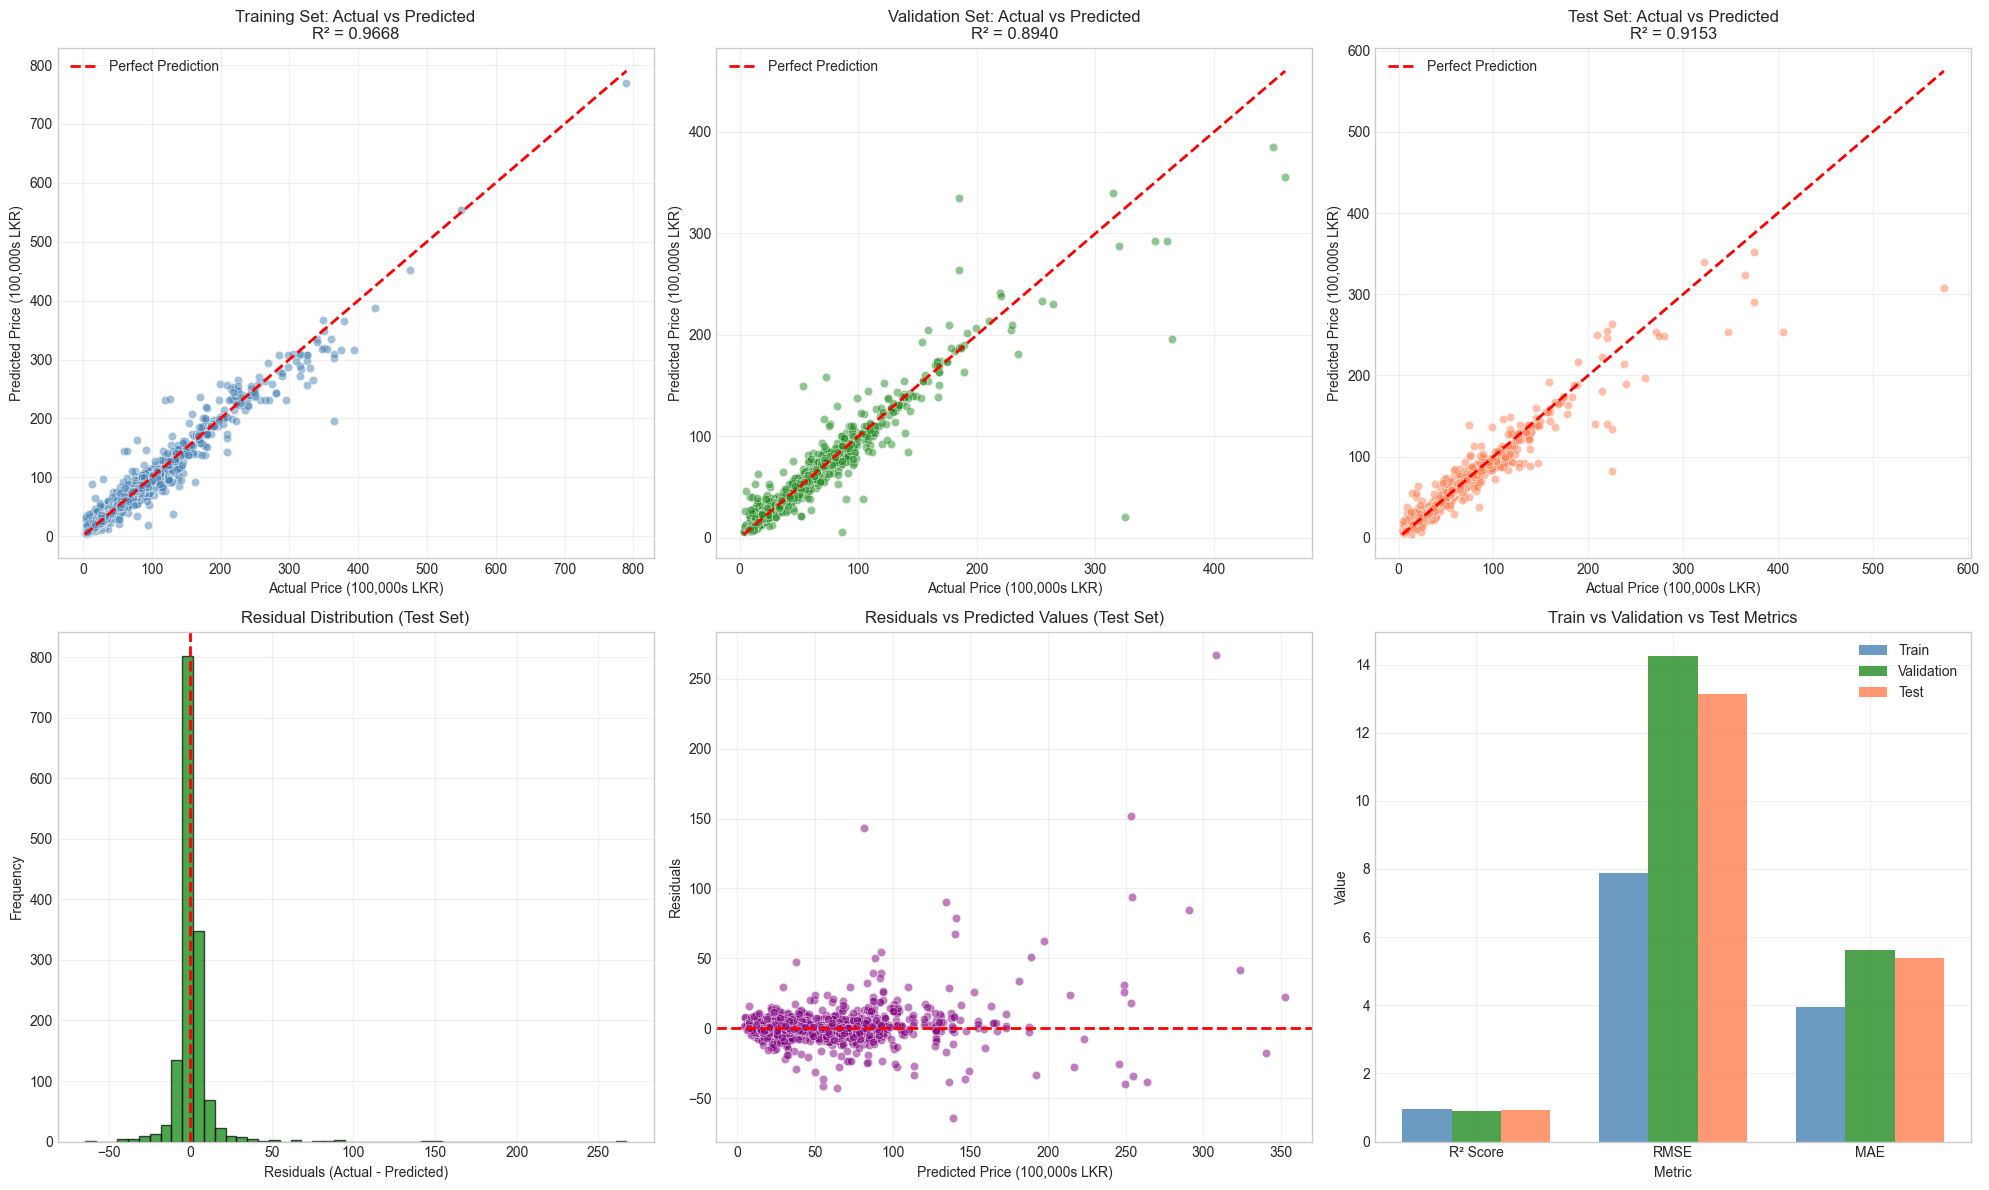

In [144]:
# Visualize model performance
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Actual vs Predicted (Training)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.5, color='steelblue', edgecolors='white', linewidth=0.5)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price (100,000s LKR)')
axes[0, 0].set_ylabel('Predicted Price (100,000s LKR)')
axes[0, 0].set_title(f'Training Set: Actual vs Predicted\nR² = {train_metrics["R² Score"]:.4f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Validation)
axes[0, 1].scatter(y_val, y_val_pred, alpha=0.5, color='forestgreen', edgecolors='white', linewidth=0.5)
axes[0, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Price (100,000s LKR)')
axes[0, 1].set_ylabel('Predicted Price (100,000s LKR)')
axes[0, 1].set_title(f'Validation Set: Actual vs Predicted\nR² = {val_metrics["R² Score"]:.4f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Actual vs Predicted (Test)
axes[0, 2].scatter(y_test, y_test_pred, alpha=0.5, color='coral', edgecolors='white', linewidth=0.5)
axes[0, 2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 2].set_xlabel('Actual Price (100,000s LKR)')
axes[0, 2].set_ylabel('Predicted Price (100,000s LKR)')
axes[0, 2].set_title(f'Test Set: Actual vs Predicted\nR² = {test_metrics["R² Score"]:.4f}')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Residual Distribution (Test)
residuals = y_test - y_test_pred
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Residual Distribution (Test Set)')
axes[1, 0].grid(True, alpha=0.3)

# 5. Residuals vs Predicted (Test)
axes[1, 1].scatter(y_test_pred, residuals, alpha=0.5, color='purple', edgecolors='white', linewidth=0.5)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Price (100,000s LKR)')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residuals vs Predicted Values (Test Set)')
axes[1, 1].grid(True, alpha=0.3)

# 6. Metrics Comparison Bar Chart
metrics_names = ['R² Score', 'RMSE', 'MAE']
train_vals = [train_metrics['R² Score'], train_metrics['RMSE'], train_metrics['MAE']]
val_vals = [val_metrics['R² Score'], val_metrics['RMSE'], val_metrics['MAE']]
test_vals = [test_metrics['R² Score'], test_metrics['RMSE'], test_metrics['MAE']]

x = np.arange(len(metrics_names))
width = 0.25
axes[1, 2].bar(x - width, train_vals, width, label='Train', color='steelblue', alpha=0.8)
axes[1, 2].bar(x, val_vals, width, label='Validation', color='forestgreen', alpha=0.8)
axes[1, 2].bar(x + width, test_vals, width, label='Test', color='coral', alpha=0.8)
axes[1, 2].set_xlabel('Metric')
axes[1, 2].set_ylabel('Value')
axes[1, 2].set_title('Train vs Validation vs Test Metrics')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(metrics_names)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 7. Explainability Analysis (SHAP)

In [145]:
# Get feature importances
feature_importance = model.get_feature_importance()
feature_names = X_train.columns.tolist()

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

import shap

# CatBoost has a built-in fast SHAP implementation via Pool objects
# Calculate SHAP values for the test set
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_pool)

print(" SHAP values calculated successfully!")
print(f" SHAP values shape: {shap_values.shape}")
print(f" Expected value (base prediction): {explainer.expected_value:.4f}")

 SHAP values calculated successfully!
 SHAP values shape: (1469, 7)
 Expected value (base prediction): 53.3011


SHAP MEAN ABSOLUTE IMPORTANCE (BAR PLOT)
Shows the average magnitude of each feature's impact



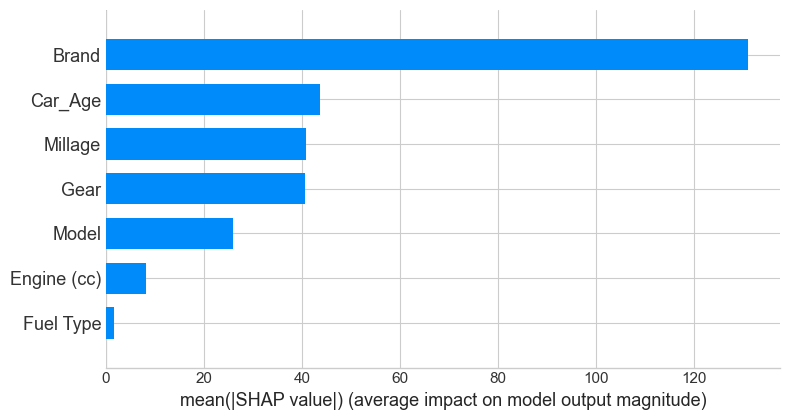

In [146]:
# 1. SHAP Bar Plot (Mean absolute SHAP values - global importance)
print("=" * 60)
print("SHAP MEAN ABSOLUTE IMPORTANCE (BAR PLOT)")
print("=" * 60)
print("Shows the average magnitude of each feature's impact\n")

shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=True)

In [147]:
# 2. SHAP Global Feature Importance Summary Table
print("=" * 60)
print("SHAP FEATURE IMPORTANCE SUMMARY")
print("=" * 60)

# Calculate mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP Value|': mean_abs_shap,
    'Importance %': (mean_abs_shap / mean_abs_shap.sum()) * 100
}).sort_values('Mean |SHAP Value|', ascending=False).reset_index(drop=True)
shap_importance_df.index += 1

print("\n Features ranked by mean absolute SHAP value:\n")
print(shap_importance_df.round(4).to_string())

# Compare CatBoost native importance vs SHAP importance
print("\n\n Key Insight: SHAP values provide a more theoretically grounded")
print("   importance measure than CatBoost's built-in feature importance,")
print("   as they account for feature interactions and have additive properties.")

SHAP FEATURE IMPORTANCE SUMMARY

 Features ranked by mean absolute SHAP value:

       Feature  Mean |SHAP Value|  Importance %
1        Brand           130.9956       44.9071
2      Car_Age            43.6390       14.9600
3      Millage            40.8642       14.0088
4         Gear            40.6790       13.9453
5        Model            25.8933        8.8766
6  Engine (cc)             8.1021        2.7775
7    Fuel Type             1.5306        0.5247


 Key Insight: SHAP values provide a more theoretically grounded
   importance measure than CatBoost's built-in feature importance,
   as they account for feature interactions and have additive properties.


#### 8. Save model

In [148]:
# Save the model
import os

model_dir = '../model'
os.makedirs(model_dir, exist_ok=True)

# Save the CatBoost model
model_path = os.path.join(model_dir, 'car_price_catboost_model.cbm')
model.save_model(model_path)

print("=" * 60)
print("MODEL SAVED SUCCESSFULLY")
print("=" * 60)
print(f"\n✅ Model saved to: {model_path}")
print(f"   Model file size: {os.path.getsize(model_path) / 1024:.2f} KB")

# Save feature names and metadata for inference
import json

model_metadata = {
    'feature_names': feature_names,
    'categorical_features': cat_features,
    'categorical_feature_indices': cat_feature_indices,
    'best_iteration': model.get_best_iteration(),
    'split_strategy': 'stratified_train_val_test (70-15-15)',
    'feature_engineering': {
        'Car_Age': 'current_year (2026) - YOM',
        'Millage': 'ceil(Millage_KM / 100)'
    },
    'metrics': {
        'train_r2': train_metrics['R² Score'],
        'val_r2': val_metrics['R² Score'],
        'test_r2': test_metrics['R² Score'],
        'train_rmse': train_metrics['RMSE'],
        'val_rmse': val_metrics['RMSE'],
        'test_rmse': test_metrics['RMSE']
    }
}

metadata_path = os.path.join(model_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=4)

print(f"✅ Metadata saved to: {metadata_path}")

MODEL SAVED SUCCESSFULLY

✅ Model saved to: ../model\car_price_catboost_model.cbm
   Model file size: 6019.28 KB
✅ Metadata saved to: ../model\model_metadata.json


In [149]:
# Load the saved model and make a sample prediction
from catboost import CatBoostRegressor

# Load model
loaded_model = CatBoostRegressor()
loaded_model.load_model(model_path)

# Sample prediction using a car from the test set
sample_idx = 0
sample_car = X_test.iloc[[sample_idx]]
actual_price = y_test.iloc[sample_idx]
predicted_price = loaded_model.predict(sample_car)[0]

print("=" * 60)
print("SAMPLE PREDICTION DEMONSTRATION")
print("=" * 60)
print("\n Sample Car Features:")
for col, value in sample_car.iloc[0].items():
    print(f"   • {col}: {value}")

print(f"\n Actual Price: {actual_price:.2f} (× 100,000 LKR) = {actual_price * 100000:,.0f} LKR")
print(f" Predicted Price: {predicted_price:.2f} (× 100,000 LKR) = {predicted_price * 100000:,.0f} LKR")
print(f" Difference: {abs(actual_price - predicted_price):.2f} (× 100,000 LKR) = {abs(actual_price - predicted_price) * 100000:,.0f} LKR")
print(f" Percentage Error: {abs(actual_price - predicted_price) / actual_price * 100:.2f}%")

SAMPLE PREDICTION DEMONSTRATION

 Sample Car Features:
   • Brand: NISSAN
   • Model: FB15 SUPER SALOON
   • Engine (cc): 1500.0
   • Gear: Automatic
   • Fuel Type: Petrol
   • Car_Age: 26
   • Millage: 2750.0

 Actual Price: 39.75 (× 100,000 LKR) = 3,975,000 LKR
 Predicted Price: 38.02 (× 100,000 LKR) = 3,801,901 LKR
 Difference: 1.73 (× 100,000 LKR) = 173,099 LKR
 Percentage Error: 4.35%
